Parse lentiMPRA data into format for training distilled MPRAnn models with mean+aleatoric+epistemic prediction.

Add the standard deviation of the ensemble predictions for the activity output (epistemic uncertainty) to the .h5 file containing the mean and aleatoric uncertainty (`/home/jessica/ensemble_distillation/data/lentiMPRA/{celltype}_data_with_aleatoric.h5`).

Also add the mean of the ensemble predictions for the activity and aleatoric uncertainty outputs for the training set to the .h5 file.

[Data source](https://www.biorxiv.org/content/10.1101/2023.03.05.531189v1.supplementary-material)
- Sequences: Supplementary Table 3
- Target values: Supplementary Table 4 (summary level data, mean column)

In [1]:
import h5py 
import pandas as pd
import numpy as np
np.random.seed(1234)
import sys
sys.path.append("../code")
from utils import load_lentiMPRA_data, downsample
from os.path import join
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

2024-07-23 19:17:09.280951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 19:17:10.172095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/lib
2024-07-23 19:17:10.172177: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/lib
2024-07-23 19:17:10.172183: W tensorflow/compiler/tf2tensorrt/util

In [11]:
heteroscedastic = True

if heteroscedastic:
    data_dir = '../data/MPRAnn_heteroscedastic'
else:
    data_dir="../data/MPRAnn_aleatoric"

# K562

## Load data w/ aleatoric std 
Adding distillation data to this file.

In [3]:
celltype = 'K562'
evoaug = False

In [4]:
X_train, y_train, X_test, y_test, X_val, y_val = load_lentiMPRA_data(f'../data/lentiMPRA/{celltype}_data_with_aleatoric.h5')

In [5]:
assert(y_train.shape[-1]==2)
assert(y_test.shape[-1]==2)
assert(y_val.shape[-1]==2)

In [6]:
X_train.shape

(180564, 230, 4)

In [7]:
X_test.shape

(22571, 230, 4)

In [8]:
X_val.shape

(22570, 230, 4)

## Load epistemic std data

- col0 = ensemble std of mean
- col1 = ensemble std of aleatoric uncertainty

In [12]:
if evoaug:
    epistemic_train = np.load(join(data_dir, 'evoaug', f'{celltype}_ensemble_std_train.npy'))
    epistemic_test = np.load(join(data_dir, 'evoaug', f'{celltype}_ensemble_std_test.npy'))
    epistemic_val = np.load(join(data_dir, 'evoaug', f'{celltype}_ensemble_std_val.npy'))
else:
    epistemic_train = np.load(join(data_dir, f'{celltype}_ensemble_std_train.npy'))
    epistemic_test = np.load(join(data_dir, f'{celltype}_ensemble_std_test.npy'))
    epistemic_val = np.load(join(data_dir, f'{celltype}_ensemble_std_val.npy'))

In [13]:
# check dims 
assert(epistemic_train.shape[0]==y_train.shape[0])
assert(epistemic_test.shape[0]==y_test.shape[0])
assert(epistemic_val.shape[0]==y_val.shape[0])

In [14]:
epistemic_train.shape

(180564, 2)

## Load ensemble avg on train set

Average should be computed from ensemble of models w/ activity+aleatoric outputs.

In [15]:
if heteroscedastic:
    if evoaug:
        ensemble_avg_y_train = np.load(f'../results/MPRAnn_heteroscedastic_evoaug/{celltype}/ensemble_avg_y_train.npy')
    else:
        ensemble_avg_y_train = np.load(f'../results/MPRAnn_heteroscedastic/{celltype}/ensemble_avg_y_train.npy')
else:
    if evoaug:
        ensemble_avg_y_train = np.load(f'../results/MPRAnn_aleatoric_evoaug/{celltype}/ensemble_avg_y_train.npy')
    else:
        ensemble_avg_y_train = np.load(f'../results/MPRAnn_aleatoric/{celltype}/ensemble_avg_y_train.npy')
assert(ensemble_avg_y_train.shape[-1]==2)

### Visualize ensemble avg against ground truth data

In [16]:
pearsonr(y_train[:,0], ensemble_avg_y_train[:,0])[0]

0.8481889602190547

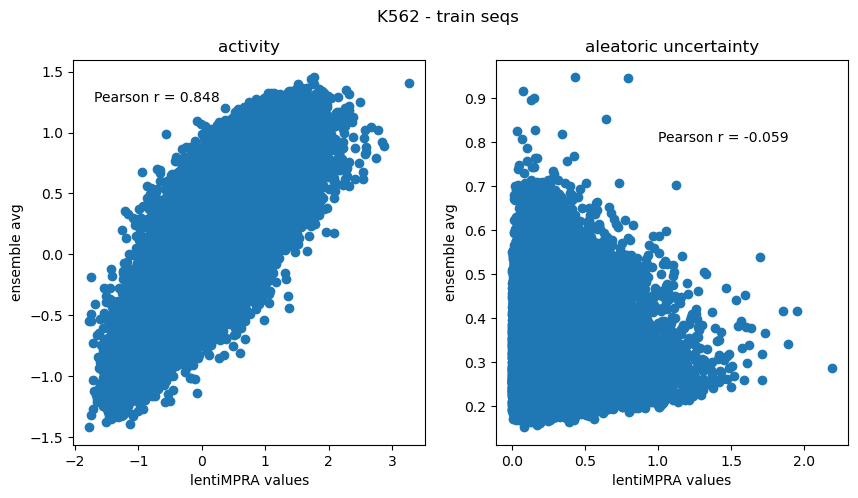

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,5))
ax1.scatter(y_train[:,0], ensemble_avg_y_train[:,0])
ax1.set_xlabel('lentiMPRA values')
ax1.set_ylabel('ensemble avg')
ax1.set_title('activity')
ax1.text(-1.7, 1.25, f"Pearson r = {pearsonr(y_train[:,0], ensemble_avg_y_train[:,0])[0]:.3f}")
ax2.scatter(y_train[:,1], ensemble_avg_y_train[:,1])
ax2.set_xlabel('lentiMPRA values')
ax2.set_ylabel('ensemble avg')
ax2.set_title('aleatoric uncertainty')
ax2.text(1, 0.8, f"Pearson r = {pearsonr(y_train[:,1], ensemble_avg_y_train[:,1])[0]:.3f}")
f.suptitle(f'{celltype} - train seqs')
plt.show()

# Update train/test/val data 
For distilling MPRAnn models w/ mean+aleatoric+epistemic.

In [27]:
distill_y_train = np.hstack((ensemble_avg_y_train, epistemic_train))
distill_y_test = np.hstack((y_test, epistemic_test))
distill_y_val = np.hstack((y_val, epistemic_val))

## Write data to h5 file

In [28]:
if evoaug:
    h5_fh = f"{data_dir}/evoaug/{celltype}_distillation_data_with_epistemic.h5"
else:
    h5_fh = f"{data_dir}/{celltype}_distillation_data_with_epistemic.h5"
with h5py.File(h5_fh, 'w') as file:
    # train
    train = file.create_group("Train")
    train.create_dataset('X', data=X_train)
    train.create_dataset('y', data=distill_y_train)

    # test 
    test = file.create_group('Test')
    test.create_dataset('X', data=X_test)
    test.create_dataset('y', data=distill_y_test)

    # val
    val = file.create_group('Val')
    val.create_dataset('X', data = X_val)
    val.create_dataset('y', data=distill_y_val)

# For downsampled data

In [32]:
downsample_arr = [0.1, 0.25, 0.5, 0.75]
# check ix 
for p in downsample_arr:
    rng = np.random.default_rng(1234)
    print(f'downsample p={p}')
    generated_ix = downsample(X_train, y_train, rng, p, return_ix=True)
    # load reference 
    ref_ix = np.load(f"../data/lentiMPRA/{celltype}_downsample{p}_ix.npy")
    assert(np.all(generated_ix==ref_ix))
    print(ref_ix.shape)

downsample p=0.1
(18056,)
downsample p=0.25
(45141,)
downsample p=0.5
(90282,)
downsample p=0.75
(135423,)


In [33]:
downsample_arr = [0.1, 0.25, 0.5, 0.75]
for p in downsample_arr:
    print(f'downsample p={p}')

    # load ix of downsampled cases
    ref_ix = np.load(f"../data/lentiMPRA/{celltype}_downsample{p}_ix.npy")

    # load ensemble metrics from files 
    ensemble_avg_y_train, std_train, std_test, std_val = None, None, None, None  

    # ensemble mean
    if evoaug:
        ensemble_avg_y_train = np.load(f"../results/MPRAnn_aleatoric_evoaug/{celltype}/downsample_{p}/ensemble_avg_y_train.npy")
    else:
        ensemble_avg_y_train = np.load(f"../results/MPRAnn_aleatoric/{celltype}/downsample_{p}/ensemble_avg_y_train.npy")

    # ensemble stdev
    std_train = np.load(f"{data_dir}/{celltype}_downsample{p}_ensemble_std_train.npy")
    std_test = np.load(f"{data_dir}/{celltype}_downsample{p}_ensemble_std_test.npy")
    std_val = np.load(f"{data_dir}/{celltype}_downsample{p}_ensemble_std_val.npy")

    # assertions
    assert(ref_ix.shape[0]==ensemble_avg_y_train.shape[0])
    assert(ref_ix.shape[0]==std_train.shape[0])
    assert(y_test.shape[0]==std_test.shape[0])
    assert(y_val.shape[0]==std_val.shape[0])
    
    distill_y_train = np.hstack((ensemble_avg_y_train, std_train))
    distill_y_test = np.hstack((y_test, std_test))
    distill_y_val = np.hstack((y_val, std_val))

    # write to h5
    # if evoaug:
    #     h5_path = f'{data_dir}/{celltype}_downsample{p}_distillation_data_with_epistemic.h5'
    # else:
    #     h5_path = f'{data_dir}/{celltype}_downsample{p}_distillation_data_with_epistemic.h5'
    h5_path = f'{data_dir}/{celltype}_downsample{p}_distillation_data_with_epistemic.h5'
    hf = h5py.File(h5_path, 'w')

    # write train data
    train = hf.create_group("Train")
    train.create_dataset("X", data = X_train[ref_ix,:,:])
    train.create_dataset("y", data=distill_y_train)

    # write test data
    test = hf.create_group("Test")
    test.create_dataset("X", data=X_test)
    test.create_dataset("y", data=distill_y_test)

    # write val data
    val = hf.create_group("Val")
    val.create_dataset("X", data=X_val)
    val.create_dataset("y", data=distill_y_val)
    hf.close()

downsample p=0.1
downsample p=0.25
downsample p=0.5
downsample p=0.75


# HepG2

## Load data w/ aleatoric std
We will be adding the distillation data to this file

In [29]:
celltype = 'HepG2'
evoaug = False

# load data w/ aleatoric std 
X_train, y_train, X_test, y_test, X_val, y_val = load_lentiMPRA_data(f'../data/lentiMPRA/{celltype}_data_with_aleatoric.h5')

# check dims
assert(y_train.shape[-1]==2)
assert(y_test.shape[-1]==2)
assert(y_val.shape[-1]==2)

## Load epistemic std data

- col0 = ensemble std of mean
- col1 = ensemble std of aleatoric uncertainty

In [30]:
if evoaug:
    epistemic_train = np.load(join(data_dir, 'evoaug', f'{celltype}_ensemble_std_train.npy'))
    epistemic_test = np.load(join(data_dir, 'evoaug', f'{celltype}_ensemble_std_test.npy'))
    epistemic_val = np.load(join(data_dir, 'evoaug', f'{celltype}_ensemble_std_val.npy'))
else:
    epistemic_train = np.load(join(data_dir, f'{celltype}_ensemble_std_train.npy'))
    epistemic_test = np.load(join(data_dir, f'{celltype}_ensemble_std_test.npy'))
    epistemic_val = np.load(join(data_dir, f'{celltype}_ensemble_std_val.npy'))

In [31]:
# check dims 
assert(epistemic_train.shape[0]==y_train.shape[0])
assert(epistemic_test.shape[0]==y_test.shape[0])
assert(epistemic_val.shape[0]==y_val.shape[0])

## Load ensemble avg on train set

Average should be computed from ensemble of models w/ activity+aleatoric outputs.

In [32]:
if heteroscedastic:
    if evoaug:
        ensemble_avg_y_train = np.load(f'../results/MPRAnn_heteroscedastic_evoaug/{celltype}/ensemble_avg_y_train.npy')
    else:
        ensemble_avg_y_train = np.load(f'../results/MPRAnn_heteroscedastic/{celltype}/ensemble_avg_y_train.npy')
else:
    if evoaug:
        ensemble_avg_y_train = np.load(f'../results/MPRAnn_aleatoric_evoaug/{celltype}/ensemble_avg_y_train.npy')
    else:
        ensemble_avg_y_train = np.load(f'../results/MPRAnn_aleatoric/{celltype}/ensemble_avg_y_train.npy')
assert(ensemble_avg_y_train.shape[-1]==2)

### Visualize ensemble avg against ground truth data

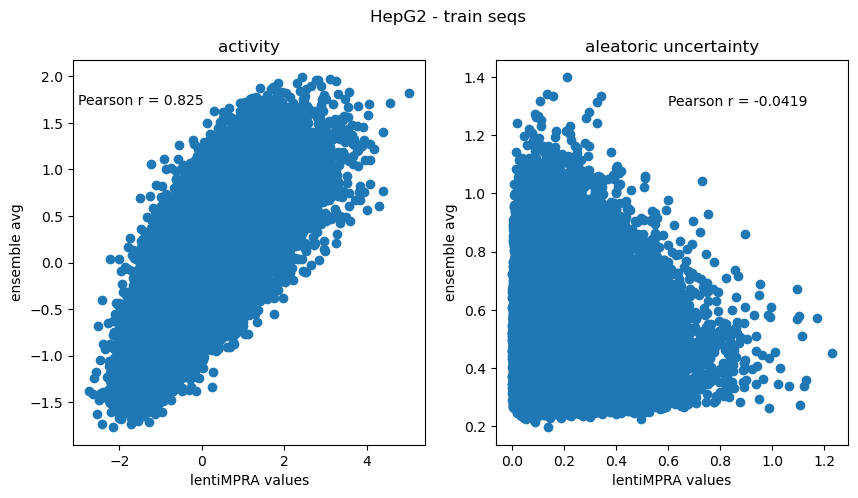

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,5))
ax1.scatter(y_train[:,0], ensemble_avg_y_train[:,0])
ax1.set_xlabel('lentiMPRA values')
ax1.set_ylabel('ensemble avg')
ax1.set_title('activity')
ax1.text(-3, 1.7, f'Pearson r = {pearsonr(y_train[:,0], ensemble_avg_y_train[:,0])[0]:.3g}')
ax2.scatter(y_train[:,1], ensemble_avg_y_train[:,1])
ax2.set_xlabel('lentiMPRA values')
ax2.set_ylabel('ensemble avg')
ax2.set_title('aleatoric uncertainty')
ax2.text(0.6, 1.3, f'Pearson r = {pearsonr(y_train[:,1], ensemble_avg_y_train[:,1])[0]:.3g}')
f.suptitle(f'{celltype} - train seqs')
plt.show()

# Update train/test/val data 
For distilling lentiMPRA models w/ mean+aleatoric+epistemic.

In [37]:
distill_y_train = np.hstack((ensemble_avg_y_train, epistemic_train))
distill_y_test = np.hstack((y_test, epistemic_test))
distill_y_val = np.hstack((y_val, epistemic_val))

## Write data to h5 file

In [38]:
if evoaug:
    h5_fh = f"{data_dir}/evoaug/{celltype}_distillation_data_with_epistemic.h5"
else:
    h5_fh = f"{data_dir}/{celltype}_distillation_data_with_epistemic.h5"
with h5py.File(h5_fh, 'w') as file:
    # train
    train = file.create_group("Train")
    train.create_dataset('X', data=X_train)
    train.create_dataset('y', data=distill_y_train)

    # test 
    test = file.create_group('Test')
    test.create_dataset('X', data=X_test)
    test.create_dataset('y', data=distill_y_test)

    # val
    val = file.create_group('Val')
    val.create_dataset('X', data = X_val)
    val.create_dataset('y', data=distill_y_val)

## For downsampled data

In [45]:
downsample_arr = [0.1, 0.25, 0.5, 0.75]
# check ix 
for p in downsample_arr:
    rng = np.random.default_rng(1234)
    print(f'downsample p={p}')
    generated_ix = downsample(X_train, y_train, rng, p, return_ix=True)
    # load reference 
    ref_ix = np.load(f"../data/lentiMPRA/{celltype}_downsample{p}_ix.npy")
    assert(np.all(generated_ix==ref_ix))

downsample p=0.1
downsample p=0.25
downsample p=0.5
downsample p=0.75


In [46]:
downsample_arr = [0.1, 0.25, 0.5, 0.75]

for p in downsample_arr:
    print(f'downsample p={p}')

    # load ix of downsampled cases
    ref_ix = np.load(f"../data/lentiMPRA/{celltype}_downsample{p}_ix.npy")

    # load ensemble metrics from files 
    ensemble_avg_y_train, std_train, std_test, std_val = None, None, None, None  

    # ensemble mean
    if evoaug:
        ensemble_avg_y_train = np.load(f"../results/MPRAnn_aleatoric_evoaug/{celltype}/downsample_{p}/ensemble_avg_y_train.npy")
    else:
        ensemble_avg_y_train = np.load(f"../results/MPRAnn_aleatoric/{celltype}/downsample_{p}/ensemble_avg_y_train.npy")

    # ensemble stdev
    if evoaug:
        std_train = np.load(f"{data_dir}/evoaug/{celltype}_downsample{p}_ensemble_std_train.npy")
        std_test = np.load(f"{data_dir}/evoaug/{celltype}_downsample{p}_ensemble_std_test.npy")
        std_val = np.load(f"{data_dir}/evoaug/{celltype}_downsample{p}_ensemble_std_val.npy")
    else:
        std_train = np.load(f"{data_dir}/{celltype}_downsample{p}_ensemble_std_train.npy")
        std_test = np.load(f"{data_dir}/{celltype}_downsample{p}_ensemble_std_test.npy")
        std_val = np.load(f"{data_dir}/{celltype}_downsample{p}_ensemble_std_val.npy")

    # assertions
    assert(ref_ix.shape[0]==ensemble_avg_y_train.shape[0])
    assert(ref_ix.shape[0]==std_train.shape[0])
    assert(y_test.shape[0]==std_test.shape[0])
    assert(y_val.shape[0]==std_val.shape[0])
    
    distill_y_train = np.hstack((ensemble_avg_y_train, std_train))
    distill_y_test = np.hstack((y_test, std_test))
    distill_y_val = np.hstack((y_val, std_val))

    print(distill_y_train.shape)
          
    # write to h5
    if evoaug:
        h5_path = f'{data_dir}/evoaug/{celltype}_downsample{p}_distillation_data_with_epistemic.h5'
    else:
        h5_path = f'{data_dir}/{celltype}_downsample{p}_distillation_data_with_epistemic.h5'
    hf = h5py.File(h5_path, 'w')

    # write train data
    train = hf.create_group("Train")
    train.create_dataset("X", data = X_train[ref_ix,:,:])
    train.create_dataset("y", data=distill_y_train)

    # write test data
    test = hf.create_group("Test")
    test.create_dataset("X", data=X_test)
    test.create_dataset("y", data=distill_y_test)

    # write val data
    val = hf.create_group("Val")
    val.create_dataset("X", data=X_val)
    val.create_dataset("y", data=distill_y_val)
    hf.close()

downsample p=0.1
(11152, 4)
downsample p=0.25
(27880, 4)
downsample p=0.5
(55759, 4)
downsample p=0.75
(83638, 4)
